In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere
import numpy as np

In [2]:
#lets start with creating a maximally entangled photon pair 
qc = QuantumCircuit(2, 2)
qc.h(0)  # put first photon in superpositon 
qc.cx(0, 1)
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
c: 2/══════════

In [3]:
# lets check the statevector
bkend =Aer.get_backend('statevector_simulator')
job = execute(qc, bkend)
sv = job.result().get_statevector(qc, decimals=3)
print(sv)

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [4]:
# Create entangled photon pair and measure it in X basis , results are same
qc = QuantumCircuit(2, 2)
qc.h(0)  # put first photon in superpositon 
qc.cx(0, 1)
qc.h([0,1])
qc.draw()

┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ H ├
     └───┘┌─┴─┐├───┤
q_1: ─────┤ X ├┤ H ├
          └───┘└───┘
c: 2/═══════════════

In [5]:
# measure and check the state vector
bkend =Aer.get_backend('statevector_simulator')
job = execute(qc, bkend)
sv = job.result().get_statevector(qc, decimals=3)
print(sv)

[0.70710678-8.65956056e-17j 0.        +8.65956056e-17j
 0.        +8.65956056e-17j 0.70710678-8.65956056e-17j]


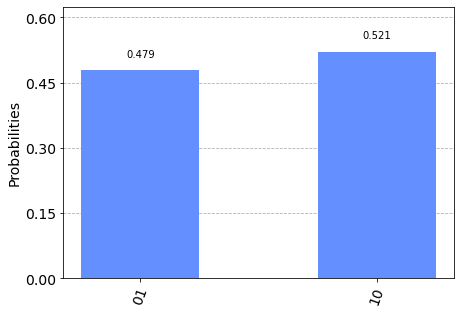

In [33]:
# run QASm simulator to capture measurement statistics
qc.measure([0,1], [0,1])
bkend = Aer.get_backend('qasm_simulator')
job = execute(qc, bkend, shots=1000)
counts = job.result().get_counts(qc)
plot_histogram(counts)

In [34]:
from qiskit.circuit.library import XGate, YGate, ZGate, IGate
# Calculate an operator associated with the rotation about an arbitary axis
def ArbRotOperator(ncap, angle):
    Ux = XGate(); Uy =  YGate();   Uz = ZGate() ; Ui = IGate();
# OR if you want you can define Paulis 
# Px = np.array([[0,1],[1,0]]); Py = np.array([[0,-1.j],[1.j,0]]); Pz = np.array([[1,0],[0,-1]])
    Oper_r = np.dot(np.cos(angle/2), Ui.to_matrix()) 
    ns = ncap[0]*Ux.to_matrix() + ncap[1]*Uy.to_matrix() + ncap[2]*Uz.to_matrix()
    Oper_i = 1.j * np.sin(angle/2)*ns
    Oper = Oper_r - Oper_i 
    Multiplier = np.exp(1.j*np.pi/2) # take care of global phase
    Oper = Multiplier * Oper 
    return Oper

In [35]:
from qiskit.quantum_info.operators.operator import Operator
# define a function to map measurement correlations while measuring in differnt bases
def EntangCirCorrelation(ncap) :
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.cx(0,1)
    angle = np.pi #  rotate by 180 degrees
    cust_Oper = Operator(ArbRotOperator(ncap, np.pi))
    qc.unitary(cust_Oper,[0],label='MB')
    qc.measure([0,1],[0,1])
    bkend = Aer.get_backend('qasm_simulator')
    shots=2048
    job = execute(qc, bkend, shots=shots)
    counts = job.result().get_counts(qc)
#    print(counts)
    if '00' in counts.keys() and '11' in counts.keys() :  
        cor = (counts.get("00") + counts.get("11")) / shots
    else :
        cor = 0
    return cor

In [36]:
# define arrays for quantum and classical plots for SternGerlach Experiment 
x_q=[]
y_q=[]
x_c=[]
y_c=[]

num_orientation = 36 # number of measurement bases in pi radians    

for iter in range(num_orientation+1):   # move from measurement along Z axis to measurement along the X axis
    p_angle = iter * (np.pi/num_orientation)   
    # determine angle in radians to get corrdinates of arbitary axis and calculate rotational matrix 
    ncap = np.array([np.sin(p_angle), 0, np.cos(p_angle)])
    y_q.append(EntangCirCorrelation(ncap))
    # Angle to calculate the rotational axis is half the angle for corresponding measurement basis
    x_angle = 2 * (p_angle * 180/np.pi)  # convert radians to Degrees
    x_q.append(x_angle)  # store angle in X array for plotting
    x_c.append(x_angle) 
    # linear relations in classical case
    if x_angle <= 180 :
        y_c.append(1-1/180*(x_angle))
    else :
        y_c.append((x_angle-180)/180)
      

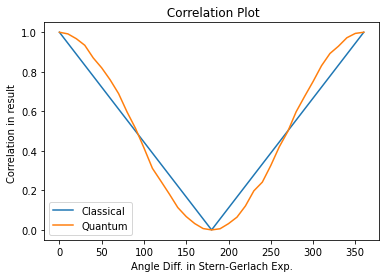

In [37]:
# plot classical predictions vs. quantum observations - exp with  electron spin  
# for an electron's spin-vector, Take note of measurements at the angles of 45, 135, 225 and 315 Degrees
import matplotlib.pyplot as plt
plt.plot(x_c, y_c)
plt.plot(x_q, y_q)
plt.xlabel('Angle Diff. in Stern-Gerlach Exp.')
plt.ylabel('Correlation in result ')
plt.title(' Correlation Plot')
plt.legend(["Classical", "Quantum"])
plt.show()

In [38]:
# define arrays for quantum and classical plots for Entangled Photons Experiment 
x_q=[]
y_q=[]
x_c=[]
y_c=[]

num_orientation = 36 # number of measurement bases in pi radians    

for iter in range(num_orientation+1):   # move from measurement along Z axis to measurement along the X axis
    p_angle = iter * (np.pi/num_orientation)   
    # determine angle in radians to get corrdinates of arbitary axis and calculate rotational matrix 
    ncap = np.array([np.sin(p_angle), 0, np.cos(p_angle)])
    y_q.append(EntangCirCorrelation(ncap))

    # Angle to calculate the rotational axis is same as the angle for corresponding measurement basis 
    # On bloch sphere to adjust the Rotational axis and Mesaurement basis we need to multiply by 2 but then to depict
    # the polarization angle (as polarizer at 90D are orthogonal to each other), we need to divide the angle by 2
    x_angle = p_angle * 180/np.pi  # convert radians to Degrees
    x_q.append(x_angle)  # store angle in X array for plotting
    x_c.append(x_angle) 
    # linear relations in classical case
    if x_angle <= 90 :
        y_c.append(1-1/90*(x_angle))
    else :
        y_c.append((x_angle-90)/90)


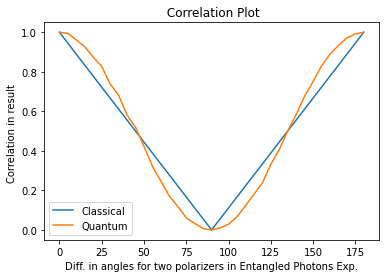

In [39]:
# plot classical predictions vs. quantum observations - exp with polarized photons
# For an entangled photon pair, Take note of measurements correlations at angle of 22.5, 67.5, 112.5 and 157.5 Degrees
import matplotlib.pyplot as plt
plt.plot(x_c, y_c)
plt.plot(x_q, y_q)
plt.xlabel('Diff. in angles for two polarizers in Entangled Photons Exp.')
plt.ylabel('Correlation in result ')
plt.title(' Correlation Plot')
plt.legend(["Classical", "Quantum"])
plt.show()

In [16]:
# end of program